In [1]:
import pandas as pd
import numpy as np
import re
import json
import os

from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras import optimizers
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
building_name = "Comsa2"
floor = "Floor2"
month = "February"

dataset_date_ini = '2020-01-15 00:00:00'
dataset_date_end = '2020-02-28 23:45:00'

visualization_date_ini = '2020-02-24 06:00:00'
visualization_date_fin = '2020-02-25 06:00:00'


ptd = 0.8
method = "step_Ti"
model = "Model3"

if method == "step_Ti":
    combination = 4
elif method == "step_dTi":
    combination = 1
elif method == "block":
    combination = 3

batch_size = 'batch_size = 72'
epochs = 'epochs = 200'

#Febrero: C = 31, R = 1, A = 0
#Julio: C = 10, R = 0.53, Aw = 6.8
if month == "February":
    R = 1
    C = 31
    Aw = 0
    
elif month == "July":
    R = 0.53
    C = 10
    Aw = 6.8
    
else:
    R = 0
    C = 0
    Aw = 0
    

dataset_path = os.path.dirname(os.getcwd())+ '\\Data\\' + floor + '\\' + building_name + '.csv'
results_path = os.path.dirname(os.getcwd()) + '\\Results\\' + floor + '\\' + month + '\\'
results_path_method = os.path.dirname(os.getcwd()) + '\\Results\\' + floor + '\\' + month + '\\' +  method + '\\'
function_path = os.path.dirname(os.getcwd())+ '\\Functions'

In [3]:
import sys
sys.path.append(function_path)
from all_functions import *

In [4]:
if not os.path.exists(results_path):
    os.makedirs(results_path)
if not os.path.exists(results_path_method):
    os.makedirs(results_path_method)
    

In [5]:
dataset = pd.read_csv(dataset_path,index_col=0)
dataset

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2
Date,,,,,,,
2019-05-01 02:00:00,NaN,25.2,15.2,0.0,129.0,24.9,25.5
2019-05-01 02:15:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 02:30:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 02:45:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 03:00:00,0.0,25.2,15.3,0.0,129.0,24.7,25.4
...,...,...,...,...,...,...,...
2020-05-01 00:45:00,0.0,23.5,17.8,0.0,129.0,23.1,23.7
2020-05-01 01:00:00,0.0,23.5,17.8,0.0,129.0,23.1,23.7
2020-05-01 01:15:00,0.0,23.5,17.7,0.0,129.0,23.1,23.7


In [6]:
data = dataset.loc[dataset_date_ini:dataset_date_end]
data = data.dropna()
data['Delta'] = pd.DatetimeIndex(data.index).to_series().diff().astype('timedelta64[m]')
data

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2,Delta
Date,,,,,,,,
2020-01-15 00:00:00,-0.05,23.70,11.2,0.0,129.0,21.5,23.90,NaN
2020-01-15 00:15:00,-0.05,23.65,11.0,0.0,129.0,21.5,23.85,15.0
2020-01-15 00:30:00,-0.05,23.60,11.0,0.0,129.0,21.5,23.80,15.0
2020-01-15 00:45:00,-0.10,23.50,10.9,0.0,129.0,21.5,23.70,15.0
2020-01-15 01:00:00,0.00,23.50,10.8,0.0,129.0,21.5,23.70,15.0
...,...,...,...,...,...,...,...,...
2020-02-28 22:45:00,-0.10,24.90,13.6,0.0,129.0,23.8,23.80,15.0
2020-02-28 23:00:00,0.00,24.90,13.6,0.0,129.0,23.8,23.80,15.0
2020-02-28 23:15:00,0.00,24.90,13.6,0.0,129.0,23.7,23.80,15.0


In [7]:
data,cont = Ph0(data,column = 'Ph')

path_cont_month = os.path.dirname(os.getcwd()) + '\\Results\\' + floor + '\\Ph0_monthly.txt'

file = open(path_cont_month, 'a+')
file.write(month+':'+str(cont)+'\n')
file.close()

In [8]:
data

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2,Delta
Date,,,,,,,,
2020-01-15 00:00:00,-0.05,23.70,11.2,0.0,0.0,21.5,23.90,NaN
2020-01-15 00:15:00,-0.05,23.65,11.0,0.0,0.0,21.5,23.85,15.0
2020-01-15 00:30:00,-0.05,23.60,11.0,0.0,0.0,21.5,23.80,15.0
2020-01-15 00:45:00,-0.10,23.50,10.9,0.0,0.0,21.5,23.70,15.0
2020-01-15 01:00:00,0.00,23.50,10.8,0.0,0.0,21.5,23.70,15.0
...,...,...,...,...,...,...,...,...
2020-02-28 22:45:00,-0.10,24.90,13.6,0.0,0.0,23.8,23.80,15.0
2020-02-28 23:00:00,0.00,24.90,13.6,0.0,0.0,23.8,23.80,15.0
2020-02-28 23:15:00,0.00,24.90,13.6,0.0,0.0,23.7,23.80,15.0


In [9]:

json_file_name = os.path.dirname(os.getcwd())+ '\\Data\\combinaciones_variables.json'


with open(json_file_name) as json_file:
    json_data = json.load(json_file)


In [10]:
if method == "step_Ti" or method == "step_dTi":
    n_pred = 1
elif method == "block":
    n_pred = 4
    

vars_ini = json_data[method][str(combination)]["variables_iniciales"]
variables_training = json_data[method][str(combination)]["variables_training"]
variables_prediction = json_data[method][str(combination)]["variables_prediction"]
n_values = len(vars_ini)

In [11]:
vars_ini

['Ti(t)', 'Ta(t)', 'Ps(t)', 'Ph(t)']

In [12]:
variables_training

['Ti(t)', 'Ta(t+1)', 'Ps(t+1)', 'Ph(t+1)']

In [13]:
variables_prediction

['Ti(t+1)']

In [14]:
if method == "step_Ti":
    if month == 'July' or month=='February':
        dic_ind_date, n_train, Ti_mean, df_count, df_count_RC, df_events, df_RC = ml_algorithm(
            building_name = building_name, 
            method = method, 
            floor = floor,
            month = month,
            vars_ini = vars_ini,
            variables_training = variables_training,
            variables_prediction = variables_prediction,
            data =  data, 
            n_pred = n_pred, 
            n_values = n_values,
            percentage_train_data = ptd,
            results_path = results_path,
            results_path_method = results_path_method,
            date_1 = visualization_date_ini,
            date_2 = visualization_date_fin,
            R = R,
            C = C,
            Aw = Aw)
    else: 
        dic_ind_date, n_train = ml_algorithm(
            building_name = building_name, 
            method = method, 
            floor = floor,
            month = month,
            vars_ini = vars_ini,
            variables_training = variables_training,
            variables_prediction = variables_prediction,
            data =  data, 
            n_pred = n_pred, 
            n_values = n_values,
            percentage_train_data = ptd,
            results_path = results_path,
            results_path_method = results_path_method,
            date_1 = visualization_date_ini,
            date_2 = visualization_date_fin,
            R = R,
            C = C,
            Aw = Aw)
    
elif method == "step_dTi":
    if month == 'July' or month=='February':
        dic_ind_date, n_train, Ti_mean, df_count, df_count_RC, df_events, df_RC = ml_algorithm(
            building_name = building_name, 
            method = method, 
            floor = floor,
            month = month,
            vars_ini = vars_ini,
            variables_training = variables_training,
            variables_prediction = variables_prediction,
            data =  data, 
            n_pred = n_pred, 
            n_values = n_values,
            percentage_train_data = ptd,
            results_path = results_path,
            results_path_method = results_path_method,
            date_1 = visualization_date_ini,
            date_2 = visualization_date_fin,
            R = R,
            C = C,
            Aw = Aw)
    else:
        dic_ind_date, n_train = ml_algorithm(
            building_name = building_name, 
            method = method, 
            floor = floor,
            month = month,
            vars_ini = vars_ini,
            variables_training = variables_training,
            variables_prediction = variables_prediction,
            data =  data, 
            n_pred = n_pred, 
            n_values = n_values,
            percentage_train_data = ptd,
            results_path = results_path,
            results_path_method = results_path_method,
            date_1 = visualization_date_ini,
            date_2 = visualization_date_fin,
            R = R,
            C = C,
            Aw = Aw)
        
    
elif method == 'block':
    dic_ind_date, n_train = ml_algorithm(
        building_name = building_name, 
        method = method, 
        floor = floor,
        month = month,
        vars_ini = vars_ini,
        variables_training = variables_training,
        variables_prediction = variables_prediction,
        data =  data, 
        n_pred = n_pred, 
        n_values = n_values,
        percentage_train_data = ptd,
        results_path = results_path,
        results_path_method = results_path_method,
        date_1 = visualization_date_ini,
        date_2 = visualization_date_fin,
        R = R,
        C = C,
        Aw = Aw)

reframed_0
      Ti(t+1)  Ti(t+2)    Ti(t+3)    Ti(t+4)
0       23.65     23.6  23.500000  23.500000
1       23.60     23.5  23.500000  23.500000
2       23.50     23.5  23.500000  23.400000
3       23.50     23.5  23.400000  23.400000
4       23.50     23.4  23.400000  23.299999
...       ...      ...        ...        ...
4311    25.00     25.0  25.000000  24.900000
4312    25.00     25.0  24.900000  24.900000
4313    25.00     24.9  24.900000  24.900000
4314    24.90     24.9  24.900000  24.799999
4315    24.90     24.9  24.799999  24.799999

[4316 rows x 4 columns]
reframed
          Ti(t)  Ta(t+1)  Ps(t+1)  Ph(t+1)    Ti(t+1)
0     23.700001     11.0      0.0      0.0  23.650000
1     23.650000     11.0      0.0      0.0  23.600000
2     23.600000     10.9      0.0      0.0  23.500000
3     23.500000     10.8      0.0      0.0  23.500000
4     23.500000     10.6      0.0      0.0  23.500000
...         ...      ...      ...      ...        ...
4314  25.000000     13.6      0.0    

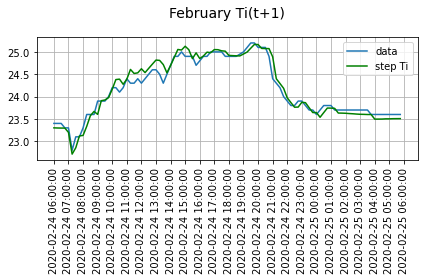

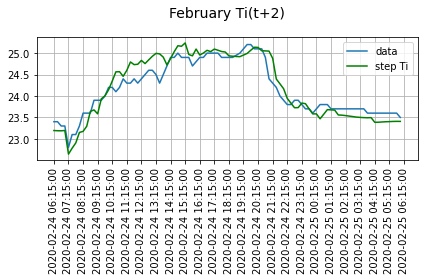

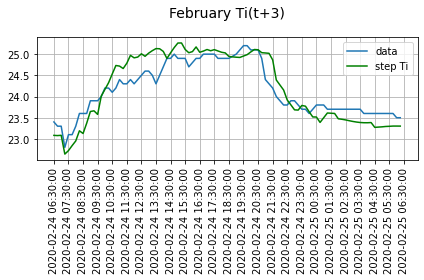

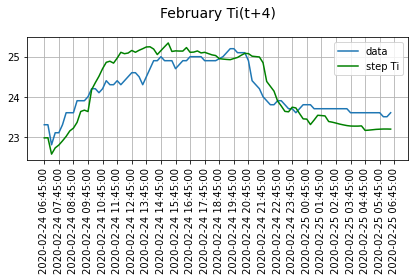

In [15]:
err_method, err_method_vis = visualization(method, building_name, floor, month, visualization_date_ini, 
                           visualization_date_fin, dic_ind_date, n_train, results_path, results_path_method)

In [16]:
results_path_method

'C:\\Users\\Saioa\\Documents\\2020-21\\Praktikak\\Programak\\COMSA\\both methods\\Results\\Floor2\\February\\step_Ti\\'

In [17]:
if not os.path.exists(results_path_method):
    os.makedirs(results_path_method+'errors.txt')
f = open (results_path_method+'errors.txt','a')
f.write('\n'+model + ': ' + str(err_method))
f.write('\n'+model + ': ' + str(err_method_vis)+'\n')
f.close()
print(model + ': ' + str(err_method))
print(model + ': ' + str(err_method_vis))

Model3: [0.13042183 0.21131507 0.28334036 0.35207   ]
Model3: [0.13978709 0.23704956 0.31866598 0.3965207 ]


In [18]:
df_count

,Flexibility,Ph moved
Date,,
2020-02-24 07:00:00,0.0,0.0
2020-02-24 07:15:00,0.0,0.0
2020-02-24 07:30:00,0.0,0.0
2020-02-24 07:45:00,0.0,0.0
2020-02-24 08:00:00,0.0,0.0
2020-02-24 08:15:00,0.0,0.0
2020-02-24 08:30:00,0.0,0.0
2020-02-24 08:45:00,0.0,0.0
2020-02-24 09:00:00,0.0,0.0


In [19]:
df_count_RC

,Flexibility,Ph moved
Date,,
2020-02-24 07:00:00,0.0,0.0
2020-02-24 07:15:00,0.0,0.0
2020-02-24 07:30:00,0.0,0.0
2020-02-24 07:45:00,0.0,0.0
2020-02-24 08:00:00,0.0,0.0
2020-02-24 08:15:00,0.0,0.0
2020-02-24 08:30:00,0.0,0.0
2020-02-24 08:45:00,0.0,0.0
2020-02-24 09:00:00,0.0,0.0


In [20]:
df_events

,2020-02-24 07:00:00,2020-02-24 07:15:00,2020-02-24 07:30:00,2020-02-24 07:45:00,2020-02-24 08:00:00,2020-02-24 08:15:00,2020-02-24 08:30:00,2020-02-24 08:45:00,2020-02-24 09:00:00,2020-02-24 09:45:00,...,2020-02-24 13:45:00,2020-02-24 14:00:00,2020-02-24 14:15:00,2020-02-24 14:30:00,2020-02-24 14:45:00,2020-02-24 15:00:00,2020-02-24 15:15:00,2020-02-24 15:30:00,2020-02-24 15:45:00,2020-02-24 16:00:00
0,23.300001,23.300001,22.799999,23.100002,23.100002,23.300001,23.600002,23.600002,23.600002,23.900002,...,24.299999,24.500002,24.700003,24.9,24.9,25.000002,24.9,24.9,24.9,24.700003
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.977285,...,24.531895,24.695488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.042635,...,24.678606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.129292,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.226282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.341175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.474705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.617661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.754076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_RC

,2020-02-24 07:00:00,2020-02-24 07:15:00,2020-02-24 07:30:00,2020-02-24 07:45:00,2020-02-24 08:00:00,2020-02-24 08:15:00,2020-02-24 08:30:00,2020-02-24 08:45:00,2020-02-24 09:00:00,2020-02-24 09:45:00,...,2020-02-24 13:45:00,2020-02-24 14:00:00,2020-02-24 14:15:00,2020-02-24 14:30:00,2020-02-24 14:45:00,2020-02-24 15:00:00,2020-02-24 15:15:00,2020-02-24 15:30:00,2020-02-24 15:45:00,2020-02-24 16:00:00
0,23.300001,23.300001,22.799999,23.100002,23.100002,23.300001,23.600002,23.600002,23.600002,23.900002,...,24.299999,24.500002,24.700003,24.9,24.9,25.000002,24.9,24.9,24.9,24.700003
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.837099,...,24.262903,24.456453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.782768,...,24.221268,24.416481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.732906,...,24.183193,24.375219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.689093,...,24.143812,24.333485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.644825,...,24.103943,24.292086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.604948,...,24.064396,24.255053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.029200,24.225576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.001545,24.193918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.971693,24.166548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
def visualization_flex(date, method_Ti, method_dTi, building_name, floor, month, dic_ind_date, n_train, Ti_mean, location, results_path_Ti, results_path_dTi,results_path):
    
    data_vis = pd.read_csv(results_path + 'data_konp_' + building_name + '.csv',index_col = 0)
    Ti_data = data_vis.iloc[n_train:,:]
    Ti_data = Ti_data.to_numpy()
    Ti_data = Ti_data.astype('float32')
    
    method_Ti_vis = pd.read_csv(results_path_Ti + method_Ti + '_pred_' + building_name + '.csv',index_col = 0)
    Ti_method = method_Ti_vis.iloc[:,:]
    Ti_method = Ti_method.to_numpy()
    Ti_method = Ti_method.astype('float32')

    method_dTi_vis = pd.read_csv(results_path_dTi + method_dTi + '_pred_' + building_name + '.csv',index_col = 0)
    dTi_method = method_dTi_vis.iloc[:,:]
    dTi_method = dTi_method.to_numpy()
    dTi_method = dTi_method.astype('float32')
    
    RC_vis= pd.read_csv(results_path + 'flex_RC.csv',index_col = 0)
    RC_flex = RC_vis.iloc[:,:]
    RC_flex = RC_flex.to_numpy()
    RC_flex = RC_flex.astype('float32')
    
    flex_Ti_vis = pd.read_csv(results_path_Ti + 'flex_Ti.csv',index_col = 0)
    Ti_flex = flex_Ti_vis.iloc[:,:]
    Ti_flex = Ti_flex.to_numpy()
    Ti_flex = Ti_flex.astype('float32')
    
    flex_dTi_vis = pd.read_csv(results_path_dTi + 'flex_dTi.csv',index_col = 0)
    dTi_flex = flex_dTi_vis.iloc[:,:]
    dTi_flex = dTi_flex.to_numpy()
    dTi_flex = dTi_flex.astype('float32')
    
    index_Ti = flex_Ti_vis.columns.get_loc(date)
    index_dTi = flex_dTi_vis.columns.get_loc(date)
    index_RC = RC_vis.columns.get_loc(date)
    key1 = get_key(date,dic_ind_date)
    key2 = key1 + len(flex_dTi_vis[date].dropna())

    
    print(key1,key2)
    date = []
    x = [k for k in range (0,key2-key1+4,4)]
    for j in range(key1,key2+4,4):
        date = np.append(date,np.array(dic_ind_date[j]))
    plt.xticks(x, date, rotation=90)

    plt.plot(Ti_data[key1-n_train-1:key2-n_train-1,0],label='Ti data',color="blue")
    
    plt.plot(Ti_method[key1-n_train-1:key2-n_train-1,0],label='Ti (Step Ti) ',color="green")
    plt.plot(dTi_method[key1-n_train-1:key2-n_train-1,0],label='Ti (Step dTi)',color="deeppink")

    plt.plot(Ti_flex[:key2-key1,index_Ti],'--',label='Ti (Ph=0 Step Ti)',color="green")
    print(len(Ti_flex[:,index_Ti]))
    plt.plot(RC_flex[:key2-key1,index_RC],'--',label='Ti (Ph=0 RC)',color="purple")
    plt.plot(dTi_flex[:key2-key1,index_dTi],'--',label='Ti (Ph=0 Step dTi)',color="deeppink")
    
    Ti_plus= [] 
    Ti_minus = []
    for i in range(key2-key1):
        Ti_plus.append(Ti_mean+1)
        Ti_minus.append(Ti_mean-1)
    plt.plot(Ti_plus,'-.',color = 'maroon')
    plt.plot(Ti_minus,'-.',color = 'maroon')
    

    plt.subplots_adjust(left=None, bottom=None, right=1.4, top=1.2, wspace=None, hspace=None)
    #plt.legend(loc = location)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True)
    plt.grid()
    name = 'flex.png'
    plt.tight_layout()
    plt.savefig(results_path + name, bbox_inches='tight', dpi = 400)
    plt.show()    

3885 3894
9


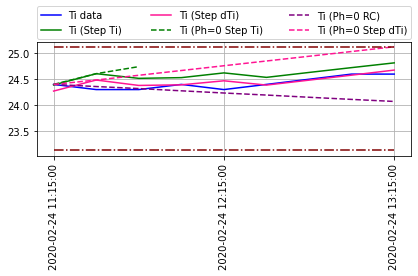

In [25]:
date = '2020-02-24 11:15:00'
method_Ti = 'step_Ti'
method_dTi = 'step_dTi'
results_path_Ti = os.path.dirname(os.getcwd()) + '\\Results\\'  + floor + '\\' + month + '\\' + method_Ti + '\\'
results_path_dTi = os.path.dirname(os.getcwd()) + '\\Results\\'  + floor + '\\' + month + '\\' + method_dTi + '\\'
location = 1
#print(index,index_RC)
visualization_flex(date, method_Ti,method_dTi, building_name, floor, month, dic_ind_date, n_train, Ti_mean, location, results_path_Ti,results_path_dTi,results_path)